# Important Notes

## Install PyQSPICE First!

In your cmd.exe window.
```
> pip install PyQSPICE
```

## After Python Script

This folder contains resulting files after running the Python Script.
The **"Sim"** folder next to this-folder is "before running script".

# Part 7 Overview

This p-FET LDO model compares its "open loop ZOUT (when VRM = OFF)" and "closed loop ZOUT (when VRM = ON)" from the
post
[part7](https://www.microwavejournal.com/articles/40953-output-impedance-zout) of a series blog/article
[RF Signal Integrity to Power Integrity](https://www.microwavejournal.com/blogs/32-rf-signal-integrity-to-power-integrity) on
[Microwave Journal](https://www.microwavejournal.com/).

We double check Zout, in time-domain, by loading the LDO with a sine load current: Zout x Iout = Vo

## This Simple P-FET LDO Model

This LDO is designed to have 5V output from its 0.5V reference voltage (VREF), so it’s a gain=10 amplifier from the view point of the VREF.

### Note on This LDO Model

This is a p-FET LDO model. The control of p-FET is "negative direction", that means the error amp "" and "-" working in opposite way. Though the feedback signal from Rfb // Rg goes into the "" port, this forms a "negative feedback loop".

## Simulation Outline

We apply a sinusoidal / AC load current to the LDO and observe its output voltage.

ZOUT = ΔVOUT / ΔIO

## Files

We start from the schematic capture **VRM_Zout.qsch**.
For your convenience, we converted the sche into the image file **VRM_Zout_sch.png**.

<img src="VRM_Zout_sch.png" width="640"/>

A Python script **VRM_Zout.py**, by loading the PyQSPICE module, convers the schematic file into netlist (**VRM_Zout.cir**) and output (**VRM_ZOUT.qraw**) files for both AC and Transient simualtions.

Then, furthermore, this Python script reads the output binary file into its memory, as Pandas DataFrame data sets and generates plot **VRM_Zout_plot.png**.

## 2nd Step

This example has the 2nd step.

The script runs a regular expression routine to convert the netlist from "ac simulation" to "transient simulation", results in the 2nd netllist **VRM_Zout_tran.cir**.

With the same steps as the 1st ones, we have the 2nd **VRM_Zout_tran_plt.png**.

## 1st Plot:  Frequency Domain
<img src="VRM_Zout_plt.png"/>

## 2nd Plot:  Time Domain

<img src="VRM_Zout_tran_plt.png"/>



# Python Code

## Execute QSPICE #1

### Execute a QSPICE simulation run and load simulation result data.

In [1]:
from PyQSPICE import clsQSPICE as pqs

import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import re

fname = "VRM_Zout"

run = pqs(fname)

run.InitPlot()

run.qsch2cir()
run.cir2qraw()

run.setNline(199)

zex = 'V(VOUT)/I(V1)'
df = (run.LoadQRAW([zex])).rename(columns = {zex: "Zout"})

df = run.GainPhase(df, "Zout", "absZo", "argZo")

run.comp2real(df, ["Step", "absZo", "argZo", run.sim['Xlbl']])
print(df)

             Freq                     Zout  Step      absZo      argZo
0    1.000000e+00 -681.679750+7914.872370j   0.0  78.000974  94.922534
1    1.096986e+00 -550.225807+7103.697984j   0.0  77.055667  94.429073
2    1.203378e+00 -446.414014+6392.849612j   0.0  76.135016  93.994492
3    1.320088e+00 -363.671456+5765.933418j   0.0  75.234635  93.609004
4    1.448118e+00 -297.199179+5210.056203j   0.0  74.350957  93.264806
..            ...                      ...   ...        ...        ...
395  6.905514e+07   -0.009258-   0.418529j   1.0  -7.563361 -91.267223
396  7.575250e+07   -0.009250-   0.459137j   1.0  -6.759388 -91.154108
397  8.309942e+07   -0.009237-   0.503682j   1.0  -5.955405 -91.050665
398  9.115888e+07   -0.009219-   0.552546j   1.0  -5.151415 -90.955912
399  1.000000e+08   -0.009193-   0.606149j   1.0  -4.347419 -90.868920

[400 rows x 5 columns]


## Frequency Domain Plot

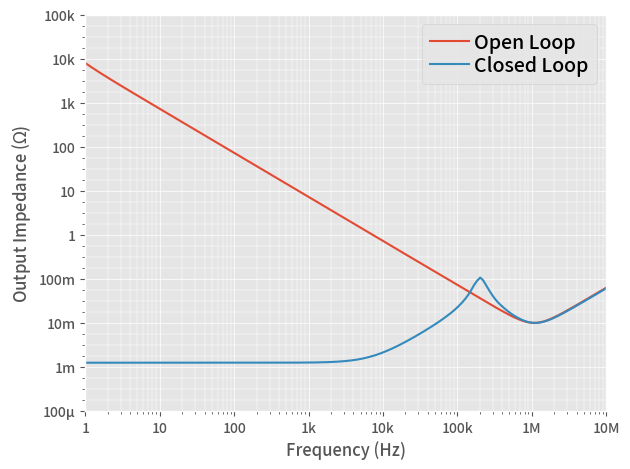

In [2]:
#######
# Plotting Pandas, AC

plt.close('all')

fig, ax = plt.subplots(tight_layout=True)
#fig.suptitle("$Z_{OUT}$")

df[df.Step == 0].plot(ax=ax, x="Freq",  y="absZo", label="Open Loop")
df[df.Step == 1].plot(ax=ax, x="Freq",  y="absZo", label="Closed Loop")
run.PrepFreqImpePlot(ax, "Frequency (Hz)", r"Output Impedance ($\Omega$)", [1,10e6], "auto")

plt.savefig(run.path['base'] + "_plt.png", format='png', bbox_inches='tight')
plt.show()

plt.close('all')

## Execute QSPICE #2

### Converting AC sim netlist => TRAN sim netlist

In [3]:
#######
# Generate Transient ".cir" from AC ".cir"

fAC = fTR = 0
ofile = ""

with open(fname + ".cir", encoding='SJIS') as f:
    for line in f:
        if "AC_end" in line: fAC = 0
        if "TRAN_end" in line: fTR = 0

        if fAC == 1: line = re.sub(r"^\.(.*)$", r"*.\1", line)
        if fTR == 1: line = re.sub(r"^\*(.*)$", r"\1", line)

        ofile = ofile + line

        if "AC_begin" in line: fAC = 1
        if "TRAN_begin" in line: fTR = 1

ftran = fname + "_tran"

with open(ftran + ".cir", 'w') as f:
    f.write(ofile)


### Execute a QSPICE simulation run and load simulation result data.

In [4]:
run2 = pqs(ftran)

run2.cir2qraw()

run2.setNline(199)

df2 = run2.LoadQRAW(["V(VOUT)"])


## Transient, Time Domain Plot

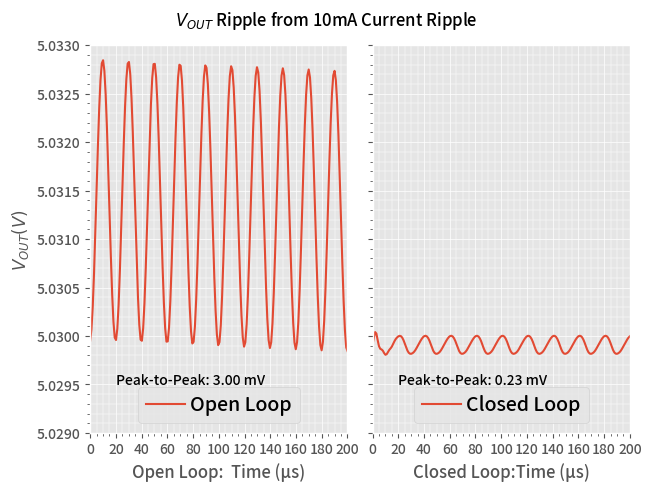

In [5]:
#######
# Plotting Pandas, Tran

plt.close('all')

fig2, (axL, axR) = plt.subplots(1,2,sharey=True,constrained_layout=True)
#fig.suptitle("$Z_{OUT}$")

df2[df2.Step == 0].plot(ax=axL, x="Time",  y="V(VOUT)", label="Open Loop")
df2[df2.Step == 1].plot(ax=axR, x="Time",  y="V(VOUT)", label="Closed Loop")

fig2.suptitle("$V_{OUT}$ Ripple from 10mA Current Ripple")

run.PrepTimePlot(axL, r"Open Loop:  Time", r"$V_{OUT} (V)$", [0,200e-6], [5.029,5.033])
run.PrepTimePlot(axR, r"Closed Loop:Time", r"$V_{OUT} (V)$", [0,200e-6], [5.029,5.033])

Lpp = (df2[df2.Step == 0])["V(VOUT)"].max() - (df2[df2.Step == 0])["V(VOUT)"].min()
Rpp = (df2[df2.Step == 1])["V(VOUT)"].max() - (df2[df2.Step == 1])["V(VOUT)"].min()

axL.text(20e-6, 5.0295, "Peak-to-Peak: {0:.2f} mV".format(Lpp*1000))
axR.text(20e-6, 5.0295, "Peak-to-Peak: {0:.2f} mV".format(Rpp*1000))

axL.legend(ncol=1, loc="lower center",fancybox=True)
axR.legend(ncol=1, loc="lower center",fancybox=True)

plt.savefig(ftran + "_plt.png", format='png', bbox_inches='tight')
plt.show()

plt.close('all')

